### Code Projet Statististiques Bayésiennes 

In [9]:
# importing necessary libraries 
import pandas as  pd 
from random import *
import numpy as np
from math import *
import matplotlib.pyplot as plt  

In [10]:
# définition des constantes 
B_0=0.2  
B_0=0.2  
n_1,n_2,n_3=200,500,1000
B_1=0.5
B_2=-0.5
sigma_2=0.25
tau_2=10000

### Données Simulées 

#### Bayesian Likelihood Estimation 

Ici, on utilise un jeu de données simulé tel que Z1 suit une loi normale centrée réduite et Z2 suit une loi bernoulli(0.5) et epsilon suit une loi normale(0,0.25). Puisqu'on a les valeurs de B0, B1 et B2, ainsi que les simulations de Z1, Z2 et epsilon, on calcule Y. 

In [44]:
def bay_max_Lik(n):
    Z_2=np.random.binomial(1, 0.5, n)
    Z_1=np.random.standard_normal(n)
    epsilon=np.random.normal(0,sqrt(0.25),n)
    Y=B_0+B_1*Z_1+B_2*Z_2+epsilon 
    C=np.ones((n,1))
    Z=np.concatenate((C,Z_1.reshape(n,1),Z_2.reshape(n,1)), axis=1)
    I_3=np.ones((3,3))
    B_BMLE=np.dot(np.linalg.inv((1/sigma_2)*np.dot(np.transpose(Z),Z)-(1/tau_2)*I_3),np.dot(np.transpose(Z),Y)*(1/sigma_2))
    return B_BMLE  

In [58]:
def bay_max_lik_var(n):
    L=[]
    for i in range(100):
        L.append(list(bay_max_Lik(n)))
    ech=np.array(L)
    std=np.array([np.std(ech[:,0]),np.std(ech[:,1]),np.std(ech[:,2])])
    return std 

In [66]:
def bay_max_lik_est(n):
    bay_max_Lik_est=np.concatenate((bay_max_Lik(n).reshape(1,3), bay_max_lik_var(n).reshape(1,3)), axis=0)
    summary=pd.DataFrame(bay_max_Lik_est, columns=['B_0','B_1','B_2'], index=['est','std'])
    print('Les estimations pour n={} sont :'.format(n))
    return summary   

In [67]:
bay_max_lik_est(200)

Les estimations pour n=200 sont :


,B_0,B_1,B_2
est,0.160891,0.532469,-0.488768
std,0.046890,0.035592,0.069918


In [68]:
bay_max_lik_est(500)

Les estimations pour n=500 sont :


,B_0,B_1,B_2
est,0.208449,0.466595,-0.482321
std,0.030371,0.025518,0.039374


In [69]:
bay_max_lik_est(1000)

Les estimations pour n=1000 sont :


,B_0,B_1,B_2
est,0.212173,0.506254,-0.531574
std,0.023428,0.014409,0.027516


Ces estimations sont très robuste et très proches des valeurs réelles dèja définies. Nos résulats ressemblent beaucoup à ceux obtenus dans l'article dans la table 1 page 197 cas de la régression linéaire. 

Dans la suite, nous allons utiliser la méthode BGMM( bayesian Generalized Method of moment) pour prédire les valeurs du vecteurs Béta. Ensuite, nous ferons une comparaison entre les deux méthodes.  

#### Bayesian Generalized Method of Moment

In [18]:
n=200
Z_2=np.random.binomial(1, 0.5, n)
Z_1=np.random.standard_normal(n)
epsilon=np.random.normal(0,sqrt(0.25),n)
Y=B_0+B_1*Z_1+B_2*Z_2+epsilon 
C=np.ones((n,1))
Z=np.concatenate((C,Z_1.reshape(n,1),Z_2.reshape(n,1)), axis=1)

In [70]:
def sigma_n_B_prime(B):
    s_1=0
    s_2=0
    for i in range(n):
        s_1+=np.dot(Z[i].reshape(3,1),np.transpose(Z[i].reshape(3,1)))*((Y[i]-np.dot(np.transpose(B),Z[i]))**2)
    for i in range(n):
        for j in range(n):
            s_2+=np.dot(Z[i].reshape(3,1),np.transpose(Z[j].reshape(3,1)))*(Y[i]-np.dot(np.transpose(B),Z[i]))*(Y[j]-np.dot(np.transpose(B),Z[j]))
    return s_1-(1/n)*s_2 

In [71]:
sigma_n_B_prime(np.array([0,0,0]))

array([[ 91.00607514,  -7.33706722,  49.57993266],
       [ -7.33706722, 140.61563643,  -8.61126795],
       [ 49.57993266,  -8.61126795,  48.06712807]])

In [171]:
###adaptive rejection Metropolis sampling algorithm within the Gibbs sampler
### LOI POSTERIORI COND DE B_0
def sim_P_B_0(B_1,B_2,y,z):  # Z ici contient uniquement Z1,i et Z2,i
    B=np.array([B_1,B_2])
    m=y-np.dot(z[:,1:],B)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for e in m:
        s_1+=e
    mean=(1/sigma_2)*s_2
    term_1=(n/sigma_2)+(1/tau_2)
    term_2=(2/sigma_2)*s_1
    var=1/(term_1+term_2)
    B_0=np.random.normal(mean,sqrt(var))
    return B_0

In [162]:
### LOI POSTERIORI COND DE B_1
def sim_P_B_1(B_0,B_2,y,z):  # Z ici contient uniquement 1 et Z2,i
    B=np.array([B_0,B_2])
    P=y-np.dot(z[:,[0,2]],B)
    L=[]
    for i in range(P.shape[0]):
        e=P[i]/z[i,1]
        L.append(e)
    m=np.array(L)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for i in range(m.shape[0]):
        s_1+=m[i]*z[i,1]
    s_3=0
    for j in range(m.shape[0]):
        s_3+=z[i,1]**2    
    mean=(1/sigma_2)*s_2
    term_1=(2/sigma_2)*s_1
    term_2=(1/sigma_2)*s_3
    var=-term_1+term_2+(1/tau_2)
    B_1=np.random.normal(mean,sqrt(var))
    B_1=np.random.normal(0.5,0.034)
    return B_1

In [163]:
### LOI POSTERIORI COND DE B_2
def sim_P_B_2(B_0,B_1,y,z):  # Z ici contient uniquement 1 et Z1,i
    B=np.array([B_0,B_1])
    P=y-np.dot(z[:,0:2],B)
    L=[]
    for i in range(P.shape[0]):
        e=P[i]/z[i,2]
        L.append(e)
    m=np.array(L)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for i in range(m.shape[0]):
        s_1+=m[i]*z[i,2]
    s_3=0
    for j in range(m.shape[0]):
        s_3+=z[i,2]**2    
    mean=(1/sigma_2)*s_2
    term_1=(2/sigma_2)*s_1
    term_2=(1/sigma_2)*s_3
    var=term_1+term_2+(1/tau_2)
    B_2=np.random.normal(mean,sqrt(var))
    return B_2

In [164]:
def gibbs_sampling_1(B_0_0,B_1_0,B_2_0,y,z,n_iter):
    sample=np.empty((n_iter,3), dtype=float)
    B_0=B_0_0
    B_1=B_1_0
    B_2=B_2_0
    for k in range(n_iter):
        L=[]
        B_0_k=sim_P_B_0(B_1,B_2,y,z)
        B_1_k=sim_P_B_1(B_0_k,B_2,y,z)
        B_2_k=sim_P_B_2(B_0_k,B_1_k,y,z)
        L.append(B_0_k)
        L.append(B_1_k)
        L.append(B_2_k)
        sample[k]=L
        B_0=B_0_k
        B_1=B_1_k
        B_2=B_2_k
    return sample

In [79]:
def BGMM_est(n, n_iter):
    Z_2=np.random.binomial(1, 0.5, n)
    Z_1=np.random.standard_normal(n)
    epsilon=np.random.normal(0,sqrt(0.25),n)
    Y=B_0+B_1*Z_1+B_2*Z_2+epsilon 
    C=np.ones((n,1))
    Z=np.concatenate((C,Z_1.reshape(n,1),Z_2.reshape(n,1)), axis=1)
    L=gibbs_sampling_1(0,0,0,Y,Z,n_iter)
    est=np.array([np.mean(L[:,0]),np.mean(L[:,1]),np.mean(L[:,2])])
    std=np.array([np.std(L[:,0]),np.std(L[:,1]),np.std(L[:,2])])
    BGMM_sum=np.concatenate((est.reshape(1,3), std.reshape(1,3)), axis=0)
    summary=pd.DataFrame( BGMM_sum, columns=['B_0','B_1','B_2'], index=['est','std'])
    print('Les estimations BGMM pour n={} sont :'.format(n))
    return summary   

Après avoir échantillonné par gibbs, nous allons estimer chaque paramètres par l'une des méthodes vues en cours. Nous allons à ce stade prendre ma médiane(qui est la moyenne dans ce cas). 

In [81]:
BGMM_est(200, 10000) 

Les estimations BGMM pour n=200 sont :


,B_0,B_1,B_2
est,0.200375,0.500269,-0.500275
std,0.049964,0.034330,0.077238


In [82]:
BGMM_est(500, 10000) 

Les estimations BGMM pour n=500 sont :


,B_0,B_1,B_2
est,0.200976,0.500079,-0.500610
std,0.049288,0.034269,0.077669


In [83]:
BGMM_est(1000, 10000) 

Les estimations BGMM pour n=1000 sont :


,B_0,B_1,B_2
est,0.199739,0.499924,-0.499618
std,0.050226,0.033824,0.076067


Text(0.5, 1.0, 'Postériori de B_0')

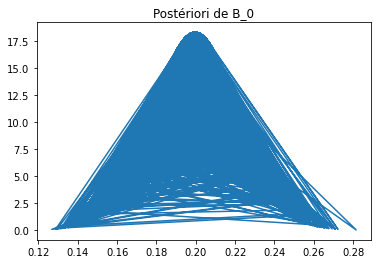

In [203]:
# Visualisation des lois a postérioris des compasantes du paramètre 
D=(1/(sqrt(2*pi)*np.std(L_3[5000:,0])))
M=np.exp((-1/(2*np.std(L_3[5000:,0])*np.std(L_3[5000:,0])))*(L_3[5000:,0]-np.mean(L_3[5000:,0]))**2)
plt.plot(L_3[5000:,0],D*M)
plt.title('Postériori de B_0')

Text(0.5, 1.0, 'Postériori de B_1')

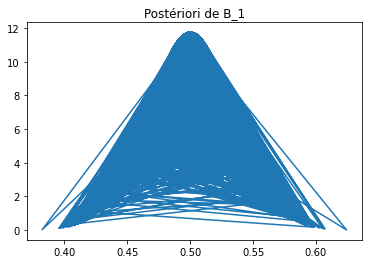

In [204]:
D=(1/(sqrt(2*pi)*np.std(L_3[5000:,1])))
M=np.exp((-1/(2*np.std(L_3[5000:,1])*np.std(L_3[5000:,1])))*(L_3[5000:,1]-np.mean(L_3[5000:,1]))**2)
plt.plot(L_3[5000:,1],D*M)
plt.title('Postériori de B_1')

Text(0.5, 1.0, 'Postériori de B_2')

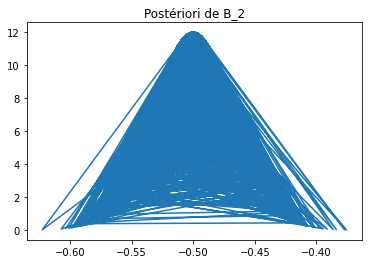

In [205]:
D=(1/(sqrt(2*pi)*np.std(L_3[5000:,2])))
M=np.exp((-1/(2*np.std(L_3[5000:,2])*np.std(L_3[5000:,2])))*(L_3[5000:,2]-np.mean(L_3[5000:,2]))**2)
plt.plot(L_3[5000:,2],D*M)
plt.title('Postériori de B_2')

### Données Réelles 

#### Compréhension des données 

In [145]:
Dataset=pd.read_csv('FuelConsumptionCo2.csv')
df=Dataset[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
df.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244


##### `FuelConsumption.csv`:


Nous avons télécharger un dataset de consommaton de carburant,**`FuelConsumption.csv`**, qui contient la consomation en carburant de chaque modèle de voiture et ses émissions CO2 pour les voitures au Canada.le dataset est composée d'un échantillon de 1067 modèles de voitures. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01)

*   **ENGINE SIZE** e.g. 4.7
*   **CYLINDERS** e.g 6
*   **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
*   **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0

#### Bayesian Likelihood Estimation 

In [152]:
def bay_max_Lik_reel():
    data=np.asanyarray(df)
    id=np.ones((data.shape[0],1))
    Z=np.concatenate((id,data[:,0:3]), axis=1)
    Y=data[:,3].reshape(1067,1)
    I_4=np.ones((4,4))
    B_BMLE=np.dot(np.linalg.inv((1/sigma_2)*np.dot(np.transpose(Z),Z)-(1/tau_2)*I_4),np.dot(np.transpose(Z),Y)*(1/sigma_2))
    return B_BMLE  

In [159]:
def bay_max_lik_var_reel():
    L=[]
    for i in range(1000):
        L.append(list(bay_max_Lik_reel()))
    ech=np.array(L)
    std=np.array([np.std(ech[:,0]),np.std(ech[:,1]),np.std(ech[:,2]),np.std(ech[:,3]) ])
    return std 

In [157]:
def bay_max_lik_est_reel():
    bay_max_Lik_est_reel=np.concatenate((bay_max_Lik_reel().reshape(1,4), bay_max_lik_var_reel().reshape(1,4)), axis=0)
    summary=pd.DataFrame(bay_max_Lik_est_reel, columns=['B_0','B_1','B_2','B_3'], index=['est','std'])
    print('Les estimations MV sont :')
    return summary   

In [160]:
bay_max_lik_est_reel()

Les estimations MV sont :


,B_0,B_1,B_2,B_3
est,65.223328,10.855256,7.516215,9.595629e+00
std,0.000000,0.000000,0.000000,1.776357e-15


#### Bayesian Generalized Method of Moment

In [146]:
data=np.asanyarray(df)
id=np.ones((data.shape[0],1))
Z=np.concatenate((id,data[:,0:3]), axis=1)
Y=data[:,3].reshape(1067,1)

In [166]:
### LOI POSTERIORI COND DE B_0
def sim_P_B_0(B_1,B_2,B_3,Y,Z):  # Z ici contient uniquement Z1,i et Z2,i
    B=np.array([B_1,B_2,B_3])
    m=Y-np.dot(Z[:,1:],B)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for e in m:
        s_1+=e
    mean=(1/sigma_2)*s_2
    term_1=(n/sigma_2)+(1/tau_2)
    term_2=(2/sigma_2)*s_1
    var=1/(term_1+term_2)
    B_0=np.random.normal(mean,sqrt(var))
    return B_0

In [167]:
### LOI POSTERIORI COND DE B_1
def sim_P_B_1(B_0,B_2,B_3,Y,Z):  # Z ici contient uniquement 1 et Z2,i
    B=np.array([B_0,B_2,B_3])
    P=Y-np.dot(Z[:,[0,2]],B)
    L=[]
    for i in range(P.shape[0]):
        e=P[i]/Z[i,1]
        L.append(e)
    m=np.array(L)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for i in range(m.shape[0]):
        s_1+=m[i]*Z[i,1]
    s_3=0
    for j in range(m.shape[0]):
        s_3+=Z[i,1]**2    
    mean=(1/sigma_2)*s_2
    term_1=(2/sigma_2)*s_1
    term_2=(1/sigma_2)*s_3
    var=-term_1+term_2+(1/tau_2)
    B_1=np.random.normal(mean,sqrt(var))
    return B_1

In [169]:
### LOI POSTERIORI COND DE B_2
def sim_P_B_2(B_0,B_1,B_3,Y,Z):  # Z ici contient uniquement 1 et Z1,i
    B=np.array([B_0,B_1,B_3])
    P=Y-np.dot(Z[:,0:2],B)
    L=[]
    for i in range(P.shape[0]):
        e=P[i]/Z[i,2]
        L.append(e)
    m=np.array(L)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for i in range(m.shape[0]):
        s_1+=m[i]*Z[i,2]
    s_3=0
    for j in range(m.shape[0]):
        s_3+=Z[i,2]**2    
    mean=(1/sigma_2)*s_2
    term_1=(2/sigma_2)*s_1
    term_2=(1/sigma_2)*s_3
    var=term_1+term_2+(1/tau_2)
    B_2=np.random.normal(mean,sqrt(var))
    return B_2

In [170]:
### LOI POSTERIORI COND DE B_2
def sim_P_B_3(B_0,B_1,B_2,Y,Z):  # Z ici contient uniquement 1 et Z1,i
    B=np.array([B_0,B_1,B_2])
    P=Y-np.dot(Z[:,0:2],B)
    L=[]
    for i in range(P.shape[0]):
        e=P[i]/Z[i,2]
        L.append(e)
    m=np.array(L)
    s_2=0
    for e in m:
        s_2+=e**2
    s_1=0
    for i in range(m.shape[0]):
        s_1+=m[i]*Z[i,2]
    s_3=0
    for j in range(m.shape[0]):
        s_3+=Z[i,2]**2    
    mean=(1/sigma_2)*s_2
    term_1=(2/sigma_2)*s_1
    term_2=(1/sigma_2)*s_3
    var=term_1+term_2+(1/tau_2)
    B_3=np.random.normal(mean,sqrt(var))
    return B_3

In [132]:
def gibbs_sampling_2(B_0_0,B_1_0,B_2_0,B_3_0,n_iter):
    sample=np.empty((n_iter,4), dtype=float)
    B_0=B_0_0
    B_1=B_1_0
    B_2=B_2_0
    B_3=B_3_0
    for k in range(n_iter):
        L=[]
        B_0_k=sim_P_B_0(B_1,B_2,B_3,Y,Z)
        B_1_k=sim_P_B_1(B_0_k,B_2,B_3,Y,Z)
        B_2_k=sim_P_B_2(B_0_k,B_1_k,B_3,Y,Z)
        B_3_k=sim_P_B_2(B_0_k,B_1_k,B_2_k,Y,Z)
        L.append(B_0_k)
        L.append(B_1_k)
        L.append(B_2_k)
        L.append(B_3_k)
        sample[k]=L
        B_0=B_0_k
        B_1=B_1_k
        B_2=B_2_k
        B_3=B_3_k
    return sample

In [150]:
def BGMM_est_reel(n_iter):
    L=gibbs_sampling_2(0,0,0,0,n_iter)
    est=np.array([np.mean(L[:,0]),np.mean(L[:,1]),np.mean(L[:,2]),np.mean(L[:,3])])
    std=np.array([np.std(L[:,0]),np.std(L[:,1]),np.std(L[:,2]),np.std(L[:,3])])
    BGMM_sum=np.concatenate((est.reshape(1,4), std.reshape(1,4)), axis=0)
    summary=pd.DataFrame( BGMM_sum, columns=['B_0','B_1','B_2','B_3'], index=['est','std'])
    print('Les estimations BGMM sont :'.format(n))
    return summary   

In [151]:
BGMM_est_reel(10000)

Les estimations BGMM sont :


,B_0,B_1,B_2,B_3
est,64.999416,11.000195,7.999677,7.999847
std,0.033824,0.049818,0.083804,0.084605


Nous pouvons constater que la méthode de Bayesian GMM présentée dans l'article de Guosheng Yin marche bien dans le cas ou les méthodes classiques type MLE marchent aussi. Bayesian GMM présente une utilité particulière dans le cas ou il est difficle d'obtenir la vraissemblance. Par exemple dans le cas ou les observations sont corrélées et la structure de la correlation est non connue, obtenir la vraissemblancen'est pas possible. BGMM approxime cette vraissemblance et propose une postériori, suivant la même logique de la règle de bayes et des GMM. 